# **Estudo da Formação de Som por um Instrumento de Cordas usando Simulação Numérica**
<center>

---
*Monografia final - 7600100 - Acústica Física*

**Universidade de São Paulo**

**Instituto de Física de São Carlos**

**São Carlos, 2023**

---
<center/>

**Vinícius Bastos Marcos**  
**Número USP:** 12556715 
**Email:** viniciusbmarcos@usp.br

# Simulando a corda

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
import os

A equação diferencial que descreve o problema é:
$$
\frac{\partial^2 y}{\partial x^2} - \frac{1}{v^2} \frac{\partial^2 y}{\partial t^2} - \gamma \frac{\partial y}{\partial t} -l^2 \frac{\partial^4 y}{\partial x^4} = 0
$$

Discretizando, ficamos com 
$$
\frac{y_{n+1,m} - 2y_{n,m} + y_{n-1,m}}{(\Delta x)^2} - \frac{1}{v^2}\frac{y_{n,m+1} - 2y_{n,m} + y_{n,m-1}}{(\Delta t)^2} - \gamma \frac{y_{n,m+1}-y_{n,m-1}}{2 \Delta t} -l^2 \frac{y_{n+2,m} - 4y_{n+1,m} + 4y_{n,m} - 4y_{n-1,m} + y_{n-2,m}}{(\Delta x)^4} = 0
$$

Definindo constantes:

* Comprimento da corda de um violão  $L = 0.6m$. Com $n_x = 100$ (passos no espaço), temos que $\Delta x = \frac{0.6m}{100} = 0.6 cm$
* Escolheremos $t_{total} = 5s$ e $n_t = 10^6$, o que nos leva em $\Delta t = 5\cdot 10^{-6}s$
* A velocidade que vamos utilizar é vai depender da frequência $f$ da nota que queremos simular. Vamos considerar que a corda estará vibrando no harmônico fundamental ($L = \lambda/2$), o primeiro harmônico, mas podemos fazer modificações simples para simular de outros. A velocidade será então:
  $$
  v = \lambda f \Rightarrow v = 2Lf 
  $$

In [2]:
f = 440 # Nota lá

Condição para a estabilidade: $$v < \frac{\Delta x}{\Delta t} \Rightarrow \frac{v\Delta t}{\Delta x} < 1$$

In [3]:
v = f*2*0.6
Nx = 100
Nt = 10**6
dx = 0.6 / Nx
dt = 5 / Nt
print((v*dt)/dx)

0.44000000000000006


é satisfeita com o que escolhemos para o problema.

* Os parâmetros utilizados $\gamma = 2.6 \cdot 10^{-5} s/m$ e $l = 2\cdot 10^{-6}$. Não achei nenhuma referência que desse esses valores, apenas as ordens deles, mas eu testei alguns e os utilizados são os que o som produzido soa como o real.

In [4]:
gamma = 2.6*10**-5
l = 2*10**-6

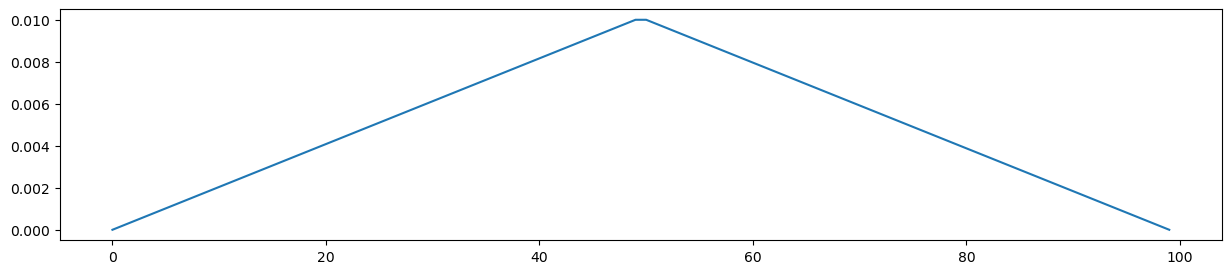

In [5]:
ya = np.linspace(0, 0.01, 50)
yb = np.linspace(0.01, 0, 50)
y0 = np.concatenate([ya, yb])
plt.figure(figsize=(15,3))
plt.plot(y0)
current_dir = os.getcwd()
plt.savefig(os.path.join(current_dir, 'inicial01.png'), bbox_inches='tight')

Agora vamos inciar nossa solução, com uma matriz de zeros que vamos atualizando no processo.

In [6]:
ysol = np.zeros((Nt, Nx))
ysol

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Colocando a condição inicial, de modo que a solução de $y=0$ e $y=1$ seja a perturbação:

In [7]:
ysol[0] = y0
ysol[1] = y0

In [8]:
ysol

array([[0.        , 0.00020408, 0.00040816, ..., 0.00040816, 0.00020408,
        0.        ],
       [0.        , 0.00020408, 0.00040816, ..., 0.00040816, 0.00020408,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Vamos isolar os $y_{n,m+1}$, que corresponde ao próximo na sequência temporal. Assim,

$$
y_{n,m+1} = \left( \frac{2v^2(\Delta t)^2}{2 + \gamma v^2 \Delta t}\right) \cdot \left[ \gamma\frac{y_{n,m-1}}{2\Delta t} - \frac{1}{v^2}\frac{y_{n,m-1} - 2y_{n,m}}{(\Delta t)^2} + l^2 \frac{y_{n+2,m} - 4y_{n+1,m} + 4y_{n,m} - 4y_{n-1,m} + y_{n-2,m}}{(\Delta x)^4} + \frac{y_{n+1,m} - 2y_{n,m} + y_{n-1,m}}{(\Delta x)^2} \right]
$$

Agora vamos utilizar o processor iterativo acima para resolver o problema (note que o vetor foi construido de forma que, ao contrário do que está escrito anteriormente, está na forma $y_{m,n}$, a ordem dos indices trocada).

In [9]:
@numba.jit("f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8, f8)", nopython=True, nogil=True) #isso acelera o processo computacional
def solution(sol, time, length, dt, dx, l, v, gamma):
    for m in range(1, time-1): #tempo
        for n in range(2, length-2): #espaço
            #como a equação é bem grande, vou dividir em fatores e somar tudo no final
            f0 = (2*(v**2)*(dt**2))/(2+(gamma*dt*(v**2)))
            f1 = gamma * (sol[m-1][n]/(2*dt))
            f2 = (1/v**2)*((sol[m-1][n] - 2*sol[m][n])/(dt**2))
            f3 = (l**2) * ((sol[m][n+2] - 4*sol[m][n+1] + 4*sol[m][n] - 4*sol[m][n-1] + sol[m][n-2])/(dx**4))
            f4 = (sol[m][n+1] - 2*sol[m][n] + sol[m][n-1])/(dx**2)
            sol[m+1][n] = f0 * (f1 - f2 + f3 + f4)

    return sol

In [10]:
solution(ysol, Nt, Nx, dt, dx, l, v, gamma) 

array([[ 0.00000000e+00,  2.04081633e-04,  4.08163265e-04, ...,
         4.08163265e-04,  2.04081633e-04,  0.00000000e+00],
       [ 0.00000000e+00,  2.04081633e-04,  4.08163265e-04, ...,
         4.08163265e-04,  2.04081633e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  4.08163248e-04, ...,
         4.08163248e-04,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -4.23143135e-13, ...,
        -4.23143135e-13,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -6.78189515e-13, ...,
        -6.78189515e-13,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -7.47726893e-13, ...,
        -7.47726893e-13,  0.00000000e+00,  0.00000000e+00]])

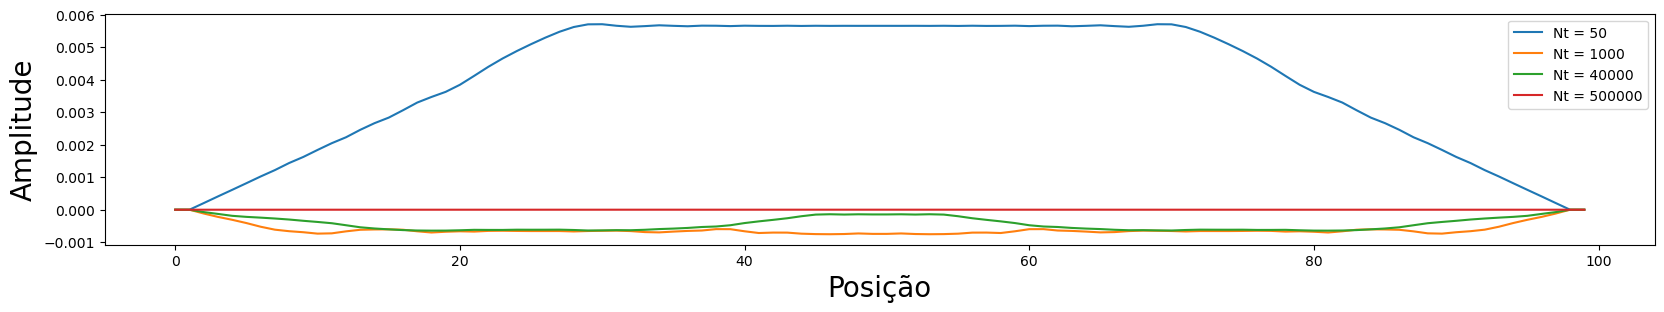

In [11]:
plt.figure(figsize=(20,3))
plt.plot(ysol[50], label='Nt = 50')
plt.plot(ysol[1000], label='Nt = 1000')
plt.plot(ysol[40000], label='Nt = 40000')
plt.plot(ysol[500000], label='Nt = 500000')
plt.legend()
plt.xlabel('Posição', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
current_dir = os.getcwd()
plt.savefig(os.path.join(current_dir, 'ondas-inicial01.png'), bbox_inches='tight')

In [12]:
len(ysol[::10,:])

100000

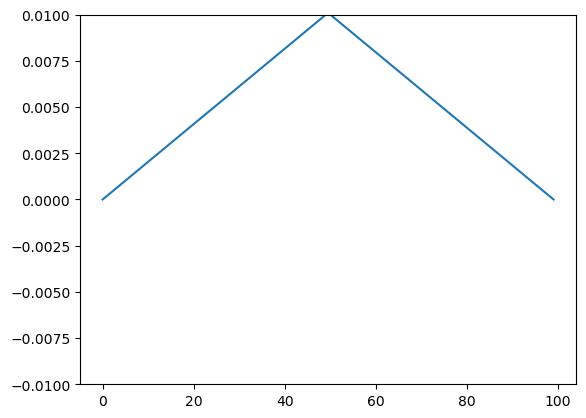

In [13]:
def animate(i):
    ax.clear()
    ax.plot(ysol[i*10])
    ax.set_ylim(-0.01, 0.01)
    
fig, ax = plt.subplots(1,1)
ax.set_ylim(-0.01, 0.01)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save(os.path.join(current_dir, 'onda_animacao-inicial01.gif'),writer='pillow',fps=20)

# Transformando em som

In [14]:
from scipy.io import wavfile
from IPython.display import Audio

O som vai ser proporcional à integral
$$
Amplitude \propto \int_0^L y(x,t)\left(\frac{n\pi x}{L} \right) dx
$$

Assim, podemos discretizar a integral em uma somatória. No caso, não precisamos fazer com todos os estados calculados.

In [15]:
def integral(n):
    sin_vec = np.sin(n*np.pi*np.linspace(0,1,100))
    return np.array([sum(sin_vec * s) for s in ysol])

In [16]:
som = [integral(n) for n in range(10)]

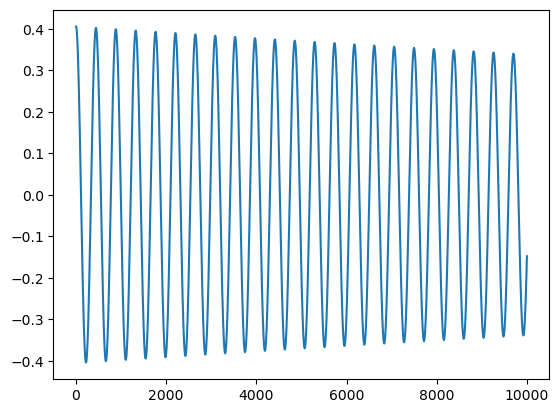

In [17]:
plt.plot(som[1][0:10000])
plt.savefig(os.path.join(current_dir, 'som-la.png'), bbox_inches='tight')

In [18]:
all_harmonics=True
if all_harmonics:
    tot = ysol.sum(axis=1)[::10] #todos os harmônicos
else:
    tot = sum(hms)[::100] #apenas os primeiros cem
tot = tot.astype(np.float32)

Criando o arquivo de aúdio que mostra nosso som da corda vibrante:

In [19]:
wavfile.write('sound-la.wav',20000,tot)
Audio('sound-la.wav')